In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
from tsforest.forecaster import LightGBMForecaster

import matplotlib.pyplot as plt
import seaborn as sns

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .dropna()
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [3]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
weights_level12.head()   

,item_id,store_id,weight
0,1613,1,1.970000e-05
1,1613,2,1.850000e-05
2,1613,3,1.430000e-05
3,1613,4,5.380000e-06
4,1613,5,5.980000e-07


In [4]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["store_id","item_id"]).rename({"q":"s"}, axis=1)
scales.head()

,store_id,item_id,s
0,1,1,1.168326
1,1,2,0.782439
2,1,3,0.886355
3,1,4,2.681374
4,1,5,1.634013


In [5]:
weights = (weights_level12
    .merge(scales, how="inner", on=["store_id","item_id"])
    .assign(weight = lambda x: x.weight/x.s)
    .assign(weight = lambda x: x.weight/x.weight.median())
    .drop(["s"], axis=1)
)
weights.head()

,item_id,store_id,weight
0,1613,1,0.930023
1,1613,2,0.623113
2,1613,3,0.361366
3,1613,4,0.430022
4,1613,5,0.025938


In [6]:
data = pd.merge(data, weights, how="left", on=["store_id","item_id"])
data.head()

,ts_id,item_id,dept_id,cat_id,store_id,state_id,y,ds,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,regular_price,discount,discount_porc,snap,weight
0,1,1,1,1,1,1,1,2013-07-18,1,1,1,1,9.58,8.26,-1.32,-0.137787,0,4.144386
1,1,1,1,1,1,1,0,2013-07-19,1,1,1,1,9.58,8.26,-1.32,-0.137787,0,4.144386
2,1,1,1,1,1,1,0,2013-07-20,1,1,1,1,9.58,8.26,-1.32,-0.137787,0,4.144386
3,1,1,1,1,1,1,0,2013-07-21,1,1,1,1,9.58,8.26,-1.32,-0.137787,0,4.144386
4,1,1,1,1,1,1,0,2013-07-22,1,1,1,1,9.58,8.26,-1.32,-0.137787,0,4.144386


***
### finding time series with few samples

In [ ]:
ts_with_few_samples = (data
                       .groupby(["item_id","store_id"])["ds"]
                       .count()
                       .reset_index(name="n_samples")
                       .query("n_samples < 29")
)
ts_with_few_samples.head()

In [ ]:
few_samples_data = (data
                    .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
                    .query("_merge == 'both'")
                    .drop("_merge", axis=1)
                    .reset_index(drop=True)
                   )

In [6]:
data = (data
        .merge(ts_with_few_samples.loc[:, ["item_id","store_id"]], how="left", indicator=True)
        .query("_merge == 'left_only'")
        .drop("_merge", axis=1)
        .reset_index(drop=True)
       )

***

In [7]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [8]:
#valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")), 
                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24"))]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')),
 (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### adds time series stats features

In [9]:
def compute_ts_stats(data, ts_uid_columns, valid_index=None, period={"days":365}):
    if valid_index is not None:
        data = data.drop(valid_index, axis=0)
    end_date = data.ds.max()
    start_date = end_date - pd.DateOffset(**period)
    result = (data
              .query("@start_date <= ds <= @end_date")
              .groupby(ts_uid_columns)
              .agg(mean_q=("y", np.mean))
              .reset_index()
              )
    return result

#ts_stats = compute_ts_stats(data, ["item_id","store_id"], valid_index, period={"days":365})
#data = pd.merge(data, ts_stats, how="left", on=["item_id", "store_id"])

***
## training

In [10]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':200,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]


model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "lags": list(range(1,15)),
    "window_functions":["mean","std"],
    "window_sizes":[7,14,28,56],
    "exclude_features":["sell_price",
                        "regular_price",
                        "ts_id",
                        "event_type_1",
                        "event_name_2",
                        "event_type_2"],
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

***
### Training validation models

In [11]:
# 5 years of history
train_history = 1825

############################################### 1/3 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.713137
[50]	valid_0's wrmsse: 0.649729
[75]	valid_0's wrmsse: 0.640338
[100]	valid_0's wrmsse: 0.637966
[125]	valid_0's wrmsse: 0.636762
[150]	valid_0's wrmsse: 0.636173
[175]	valid_0's wrmsse: 0.635835
[200]	valid_0's wrmsse: 0.635577
[225]	valid_0's wrmsse: 0.635377
[250]	valid_0's wrmsse: 0.635161
[275]	valid_0's wrmsse: 0.634968
[300]	valid_0's wrmsse: 0.634856
[325]	valid_0's wrmsse: 0.634722
[350]	valid_0's wrmsse: 0.634583
[375]	valid_0's wrmsse: 0.634556
[400]	valid_0's wrmsse: 0.634475
[425]	valid_0's wrmsse: 0.634353
[450]	valid_0's wrmsse: 0.634289
[475]	valid_0's wrmsse: 0.634169
[500]	valid

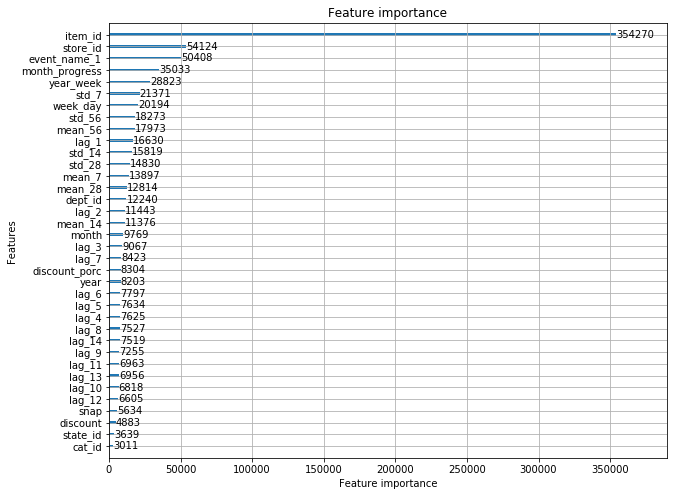

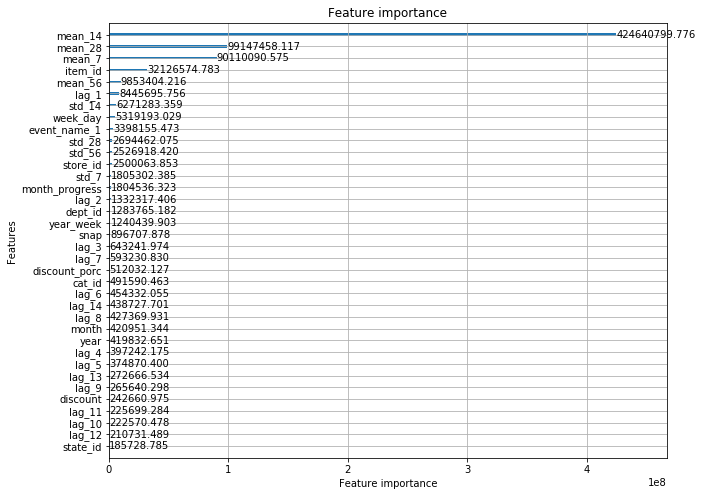

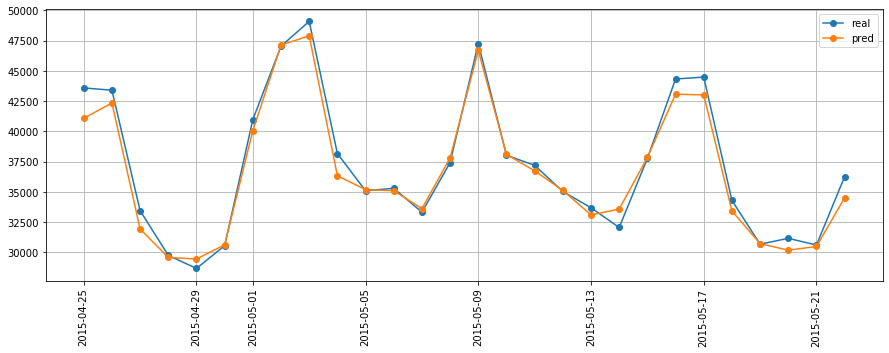

############################################### 2/3 ################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.735328
[50]	valid_0's wrmsse: 0.670682
[75]	valid_0's wrmsse: 0.660713
[100]	valid_0's wrmsse: 0.658243
[125]	valid_0's wrmsse: 0.657027
[150]	valid_0's wrmsse: 0.65629
[175]	valid_0's wrmsse: 0.65574
[200]	valid_0's wrmsse: 0.655479
[225]	valid_0's wrmsse: 0.655199
[250]	valid_0's wrmsse: 0.654919
[275]	valid_0's wrmsse: 0.654862
[300]	valid_0's wrmsse: 0.654742
[325]	valid_0's wrmsse: 0.654705
[350]	valid_0's wrmsse: 0.654638
[375]	valid_0's wrmsse: 0.654516
[400]	valid_0's wrmsse: 0.654416
[425]	valid_0's wrmsse: 0.654407
[450]	valid_0's wrmsse: 0.654357
[475]	valid_0's wrmsse: 0.654323
[500]	valid_0

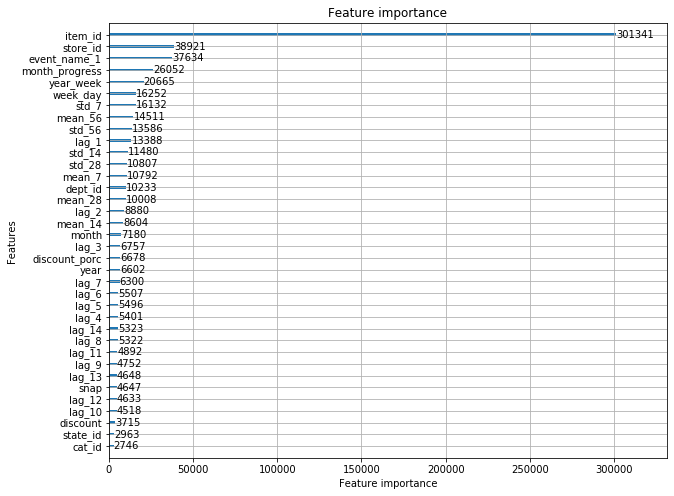

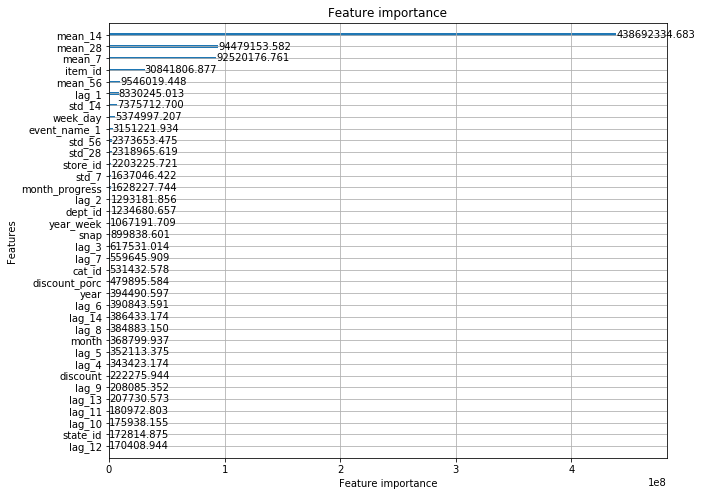

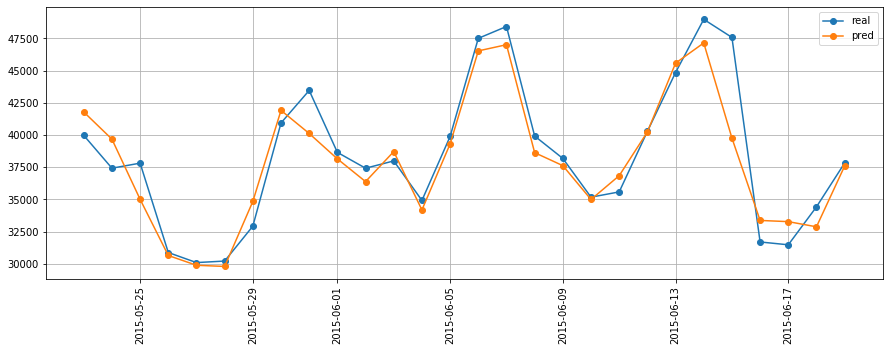

############################################### 3/3 ################################################
##### Validation period: (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.906223
[50]	valid_0's wrmsse: 0.830661
[75]	valid_0's wrmsse: 0.821303
[100]	valid_0's wrmsse: 0.819046
[125]	valid_0's wrmsse: 0.81762
[150]	valid_0's wrmsse: 0.816848
[175]	valid_0's wrmsse: 0.816582
[200]	valid_0's wrmsse: 0.816348
[225]	valid_0's wrmsse: 0.816182
[250]	valid_0's wrmsse: 0.816032
[275]	valid_0's wrmsse: 0.8158
[300]	valid_0's wrmsse: 0.815856
[325]	valid_0's wrmsse: 0.81588
[350]	valid_0's wrmsse: 0.815865
[375]	valid_0's wrmsse: 0.815705
[400]	valid_0's wrmsse: 0.815553
[425]	valid_0's wrmsse: 0.815438
[450]	valid_0's wrmsse: 0.815468
[475]	valid_0's wrmsse: 0.815443
[500]	valid_0's

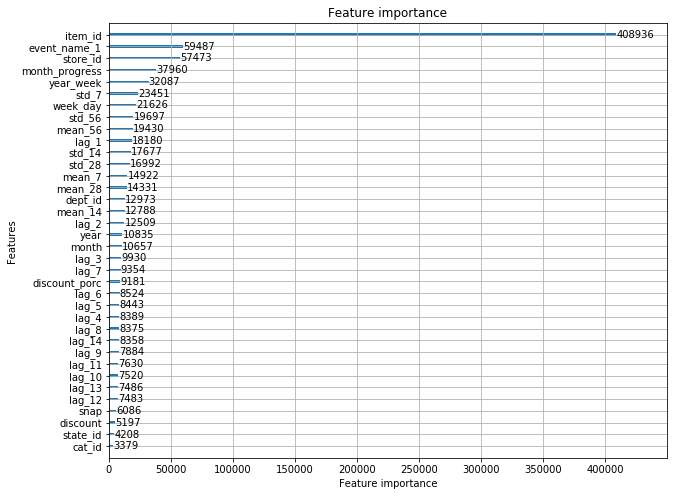

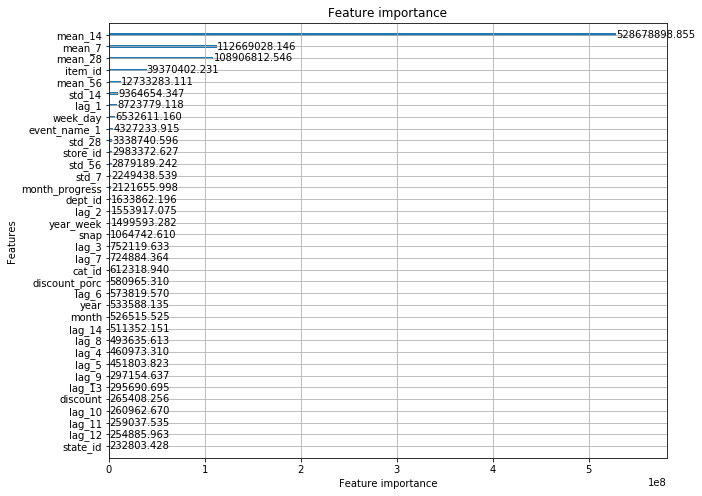

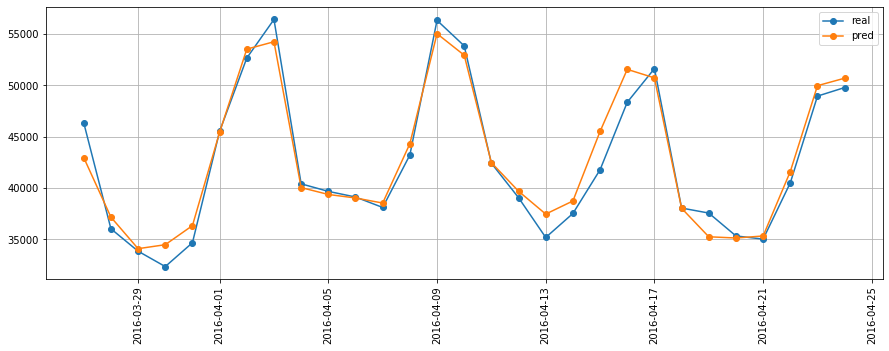

CPU times: user 2d 3h 17min 55s, sys: 4h 28min 29s, total: 2d 7h 46min 25s
Wall time: 3h 30min 4s


In [12]:
%%time

models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);
    _fcaster.train_features.dropna(inplace=True)
    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level12, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)
    
    # visualizing the predictions at level 1
    predictions = (_fcaster.valid_features
                   .loc[:, ["ds"]+_fcaster.ts_uid_columns]
                   .assign(y_pred = _fcaster.model.predict(_fcaster.valid_features))
                  )
    mrg =  (data.loc[:, ["ds","item_id","store_id","y"]]
            .merge(predictions, how="inner", on=["ds","item_id","store_id"]))
    df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()
    
    print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
    print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)
    
    plt.figure(figsize=(15,5))
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()

In [ ]:
[582]	valid_0's wrmsse: 0.813569
RMSE: 1420.1789307899646
RMSSE: 0.2396516853212219

In [15]:
int(np.mean(best_iterations))

802

In [14]:
np.mean(errors)

0.700956224023367

***
### final model

In [12]:
# 5 years of history
train_history = 1825

In [13]:
#model_kwargs["model_params"]["num_iterations"] = int(np.mean(best_iterations))
model_kwargs["model_params"]["num_iterations"] = 802
model_kwargs["model_params"]

{'objective': 'tweedie',
 'tweedie_variance_power': 1.1,
 'metric': 'None',
 'num_iterations': 802,
 'early_stopping_rounds': 200,
 'max_bin': 127,
 'bin_construct_sample_cnt': 6000000,
 'num_leaves': 1023,
 'min_data_in_leaf': 2047,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.66,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'seed': 7,
 'boost_from_average': False}

In [14]:
train_start = data.ds.max() - pd.DateOffset(days=train_history)
train_data = data.query("ds >= @train_start").reset_index(drop=True)

In [15]:
%%time
fcaster = LightGBMForecaster(**model_kwargs)
fcaster.prepare_features(train_data=train_data)
fcaster.train_features.dropna(inplace=True)

CPU times: user 15min 7s, sys: 9min 19s, total: 24min 27s
Wall time: 15min 9s


In [16]:
%%time
fcaster.train_features = reduce_mem_usage(fcaster.train_features)
fcaster.fit(fit_kwargs={"verbose_eval":20})

CPU times: user 15h 17min 52s, sys: 1h 23min 43s, total: 16h 41min 35s
Wall time: 1h 5min 23s


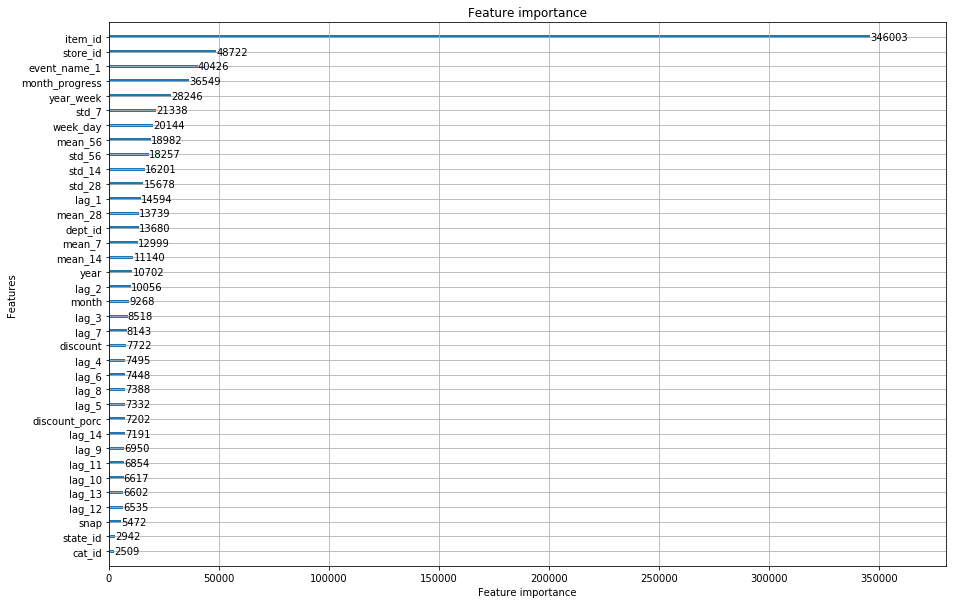

In [17]:
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));

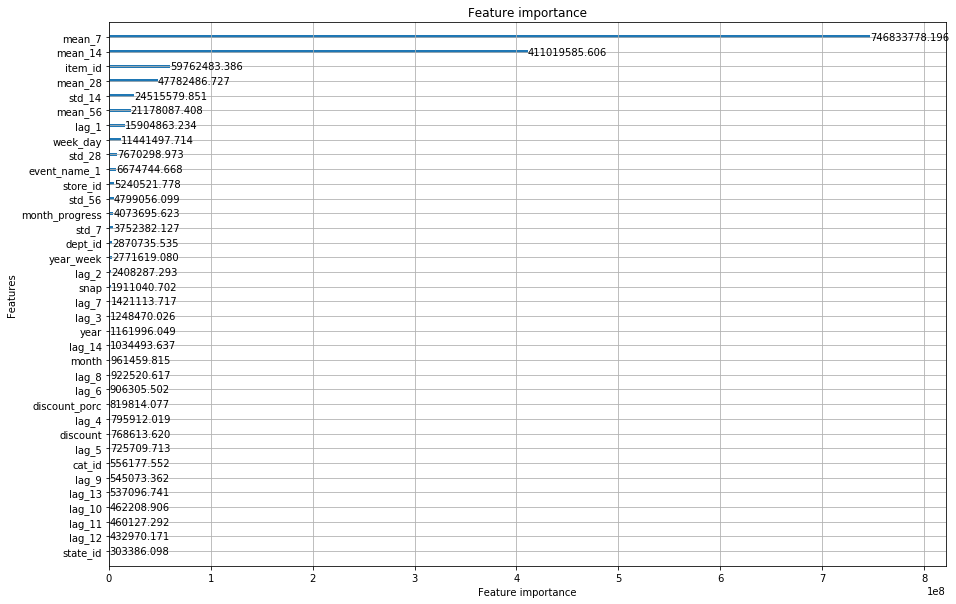

In [18]:
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***

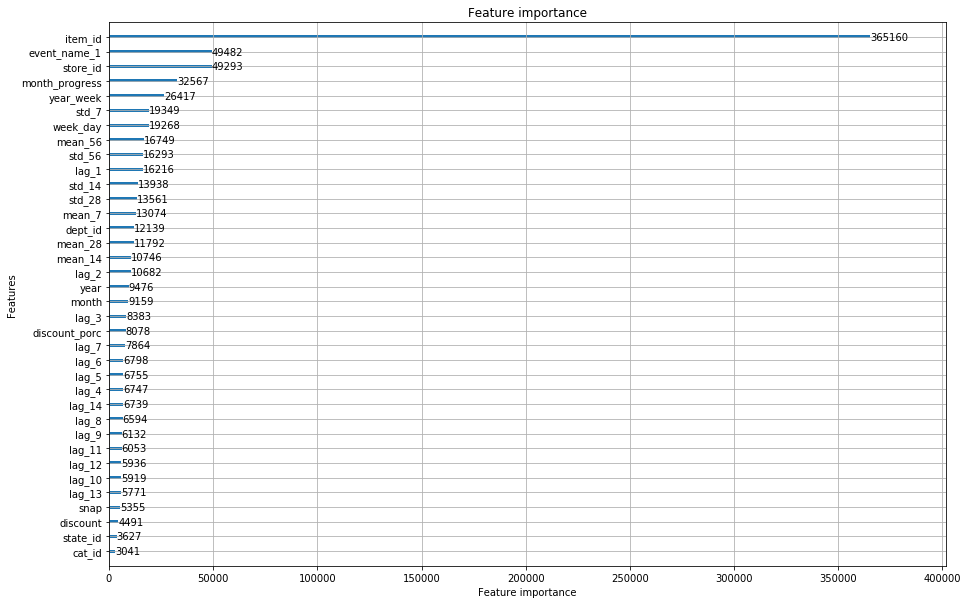

In [21]:
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));

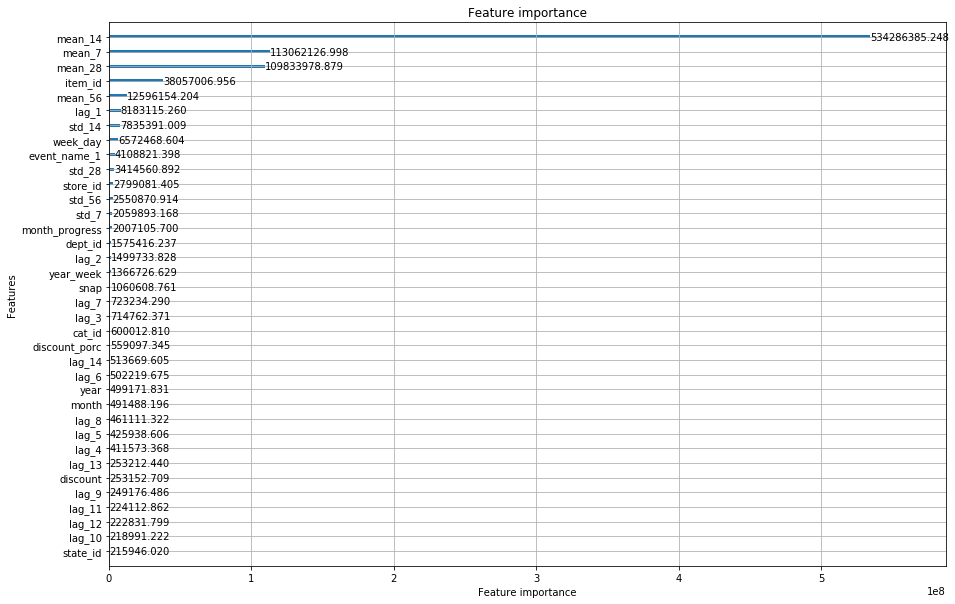

In [22]:
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
### estimating residuals

In [61]:
outfile = open("model.pkl", "wb")
pickle.dump(fcaster, outfile, protocol=4)
outfile.close()

In [2]:
model_file = open("model.pkl", "rb")
fcaster = pickle.load(model_file)
model_file.close()

In [ ]:
predict_columns = list(set(fcaster.train_data.columns) - {"y"})
predictions = fcaster.predict(fcaster.train_data.loc[:, predict_columns])

In [ ]:
residual_variance = (pd.merge(fcaster.train_data, predictions, how="inner", on=["item_id","store_id","ds"])
                     .assign(residual = lambda x: x.y - x.y_pred)
                     .groupby(["item_id","store_id"])["residual"].std()
                     .reset_index())
residual_variance

In [ ]:
residual_variance.to_parquet("../output/residuals_level12_v2.parquet", index=False)

In [ ]:
residual_variance

***
### predicting

In [19]:
valid_dataframe = pd.read_parquet("../input/valid_dataframe.parquet")
eval_dataframe = pd.read_parquet("../input/eval_dataframe.parquet")
hierarchy = pd.read_parquet("../input/hierarchy.parquet")
submission = pd.read_csv("../input/sample_submission.csv")

In [20]:
valid_dataframe = pd.merge(valid_dataframe, weights, how="left")
eval_dataframe = pd.merge(eval_dataframe, weights, how="left")

In [21]:
#valid_dataframe = (valid_dataframe
#        .merge(scale, how="left", on=["store_id","item_id"])
#        .assign(lag28 = lambda x: x.lag28/x.s)
#        .drop("s", axis=1)
#       )

## updating rolling-window features
#valid_dataframe["lag28_mean7"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(7).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean30"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(30).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean60"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(60).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean90"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(90).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean180"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(180).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_std7"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(7).std().reset_index(0, drop=True)
#valid_dataframe["lag28_std30"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(30).std().reset_index(0, drop=True)

In [22]:
#eval_dataframe = (eval_dataframe
#        .merge(scale, how="left", on=["store_id","item_id"])
#        .assign(lag28 = lambda x: x.lag28/x.s)
#        .drop("s", axis=1)
#       )

# updating rolling-window features
#eval_dataframe["lag28_mean7"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(7).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean30"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(30).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean60"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(60).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean90"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(90).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean180"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(180).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_std7"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(7).std().reset_index(0, drop=True)
#eval_dataframe["lag28_std30"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(30).std().reset_index(0, drop=True)

In [23]:
predict_dataframe = pd.concat([valid_dataframe, eval_dataframe], ignore_index=True)

In [28]:
len(predict_dataframe.loc[:, ["item_id","store_id"]].drop_duplicates())

30490

***

In [24]:
%%time
predictions = fcaster.predict(valid_dataframe, recursive=True);

CPU times: user 2h 14min 26s, sys: 18min 11s, total: 2h 32min 38s
Wall time: 1h 5min 1s


***
### predictions for validation period

In [67]:
predictions_valid = pd.merge(predictions.query("ds <= '2016-05-22'"),
                             hierarchy.loc[:, ["id", "item_id", "store_id"]], 
                             how="left")
predictions_valid["id"] = predictions_valid.id.map(lambda x: x+"_validation")

In [68]:
predictions_valid.y_pred.describe()

count    853720.000000
mean          1.511599
std           3.071005
min           0.016408
25%           0.355917
50%           0.710501
75%           1.520397
max         166.975574
Name: y_pred, dtype: float64

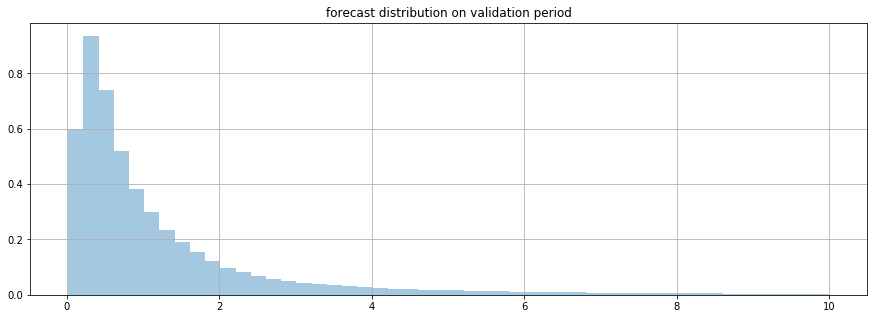

In [69]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_valid.query("y_pred < 10").y_pred.values, kde=False, norm_hist=True)
plt.title("forecast distribution on validation period")
plt.grid()

In [70]:
predictions_valid = (predictions_valid
                     .pivot(index="id", columns="ds", values="y_pred")
                     .reset_index()
                     )
predictions_valid.columns = ["id"] + [f"F{i}" for i in range (1,29)]

***
### predictions for evaluation period

In [60]:
predictions_eval = pd.merge(predictions.query("ds > '2016-05-22'"), 
                            hierarchy.loc[:, ["id", "item_id", "store_id"]],
                            how="left")
predictions_eval["id"] = predictions_eval.id.map(lambda x: x+"_evaluation")

In [61]:
predictions_eval.y_pred.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: y_pred, dtype: float64

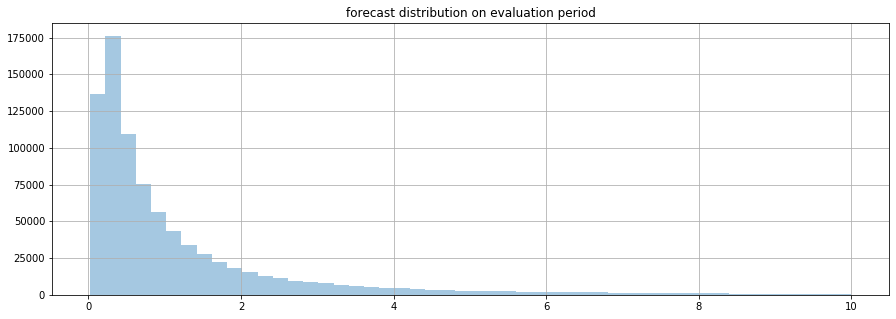

In [37]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_eval.query("y_pred < 10").y_pred.values, kde=False)
plt.title("forecast distribution on evaluation period")
plt.grid()

In [62]:
predictions_eval = (predictions_eval
                    .pivot(index="id", columns="ds", values="y_pred")
                    .reset_index()
                   )
predictions_eval.columns = ["id"] + [f"F{i}" for i in range (1,29)]

ValueError: Length mismatch: Expected axis has 1 elements, new values have 29 elements

***
### submission file

In [71]:
predictions_all = pd.concat([predictions_valid, predictions_eval], ignore_index=True)

In [41]:
assert set(predictions_all.id) == set(submission.id), \
    "there are missing time series predictions."

AssertionError: there are missing time series predictions.

In [72]:
submission.loc[0:30489, :] = pd.merge(submission.loc[:, ["id"]], predictions_all)

In [73]:
file_path = "../output/lgbm_bottom_v52.csv.gz"

if os.path.isfile(file_path):
    print("File already exists.")
else:
    submission.to_csv(file_path, index=False, compression="gzip")

In [74]:
!ls ../output

forecast_level1.csv	lgbm_bottom_v23.csv.gz	lgbm_bottom_v41.csv.gz
forecast_level2.csv	lgbm_bottom_v24.csv.gz	lgbm_bottom_v42.csv.gz
forecast_level3.csv	lgbm_bottom_v25.csv.gz	lgbm_bottom_v43.csv.gz
forecast_root.csv	lgbm_bottom_v26.csv.gz	lgbm_bottom_v44.csv.gz
kaggle_submissions	lgbm_bottom_v27.csv.gz	lgbm_bottom_v45.csv.gz
lgbm_bottom_v1.csv.gz	lgbm_bottom_v28.csv.gz	lgbm_bottom_v46.csv.gz
lgbm_bottom_v10.csv.gz	lgbm_bottom_v29.csv.gz	lgbm_bottom_v47.csv.gz
lgbm_bottom_v11.csv.gz	lgbm_bottom_v3.csv.gz	lgbm_bottom_v48.csv.gz
lgbm_bottom_v12.csv.gz	lgbm_bottom_v30.csv.gz	lgbm_bottom_v49.csv.gz
lgbm_bottom_v13.csv.gz	lgbm_bottom_v31.csv.gz	lgbm_bottom_v5.csv.gz
lgbm_bottom_v14.csv.gz	lgbm_bottom_v32.csv.gz	lgbm_bottom_v50.csv.gz
lgbm_bottom_v15.csv.gz	lgbm_bottom_v33.csv.gz	lgbm_bottom_v52.csv.gz
lgbm_bottom_v16.csv.gz	lgbm_bottom_v34.csv.gz	lgbm_bottom_v6.csv.gz
lgbm_bottom_v17.csv.gz	lgbm_bottom_v35.csv.gz	lgbm_bottom_v7.csv.gz
lgbm_bottom_v18.csv.gz	lgbm_bottom_v36.csv.gz	lgbm_bottom

In [75]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../output/lgbm_bottom_v52.csv.gz -m ""

100%|██████████████████████████████████████| 7.44M/7.44M [00:02<00:00, 3.13MB/s]
Successfully submitted to M5 Forecasting - Accuracy

***